In [15]:
"""
Here are all definitions, this must be initiated before any other cell can be run.

Gaskell Eros Shape Model V1.0 data set, ID: NEAR-A-MSI-5-EROSSHAPE-V1.0. 
"""
%matplotlib notebook
from points import *
from LS import *
from scipy.interpolate import UnivariateSpline as interpolator

# Plotting definitions
plt.rcParams['font.family'] = 'Fira Sans Medium'
plt.rcParams['font.size'] = 16
plt.style.use('dark_background')

# Function definitions
def interp(φ,Γ,ib,il):
    φn = np.linspace(0, 2*π, 200)
    vals = Γ[:, ib, il, :]
    Γip = np.zeros([φn.size, 3])

    for i in range(3):
        spl = interpolator(φ, vals[:,i])
        spl.set_smoothing_factor(0.5)
        Γip[:,i] = spl(φn)
    return φn, Γip

# Calculations are done as follows: Probe the angles determining the direction of the 
# body axis (in red). Latitude β measured as the angle between body axis and 
# illumination (in black), given by positive rotation of β in (0,π) about the x-axis. 
# Angle λ in (0,2π) corresponds to rotation about the y-axis. All in all we
# use the YX'Z''- intrinsic rotation notation, where initially rotate λ about z-axis,
# then β about the new x-axis and finally rotate the body about the final z-axis

λ = np.linspace(0, π, 50)
β = np.linspace(0, 2*π, 50)
φ = np.linspace(0, 2*π, 50)

In [16]:
"""
Here we choose which level of detail (don't worry, everything is precalculated) to use. 
This way, it is easier to compare how convergence should work here.
"""

detail_levels = ['low', 'normal', 'high']

level = 2

mesh = pymesh.load_mesh('eros_{:s}_detail.mesh'.format(detail_levels[level]))
P = mesh.nodes; T = mesh.elements
I = trimesh.Trimesh(vertices=P, faces=T, process=False).moment_inertia
Ip, Q = trimesh.inertia.principal_axis(I)
P = matmul(P,Q.T)
T, N, C = surface_normals(P, T)
mesh = pymesh.form_mesh(P,T)

In [ ]:
"""
DRAGONS! Below must be commented only if one wishes to perform precalculations again!
"""
#%%script false --no-raise-error

import time, datetime
Γ = np.zeros([φ.size, β.size, λ.size, 3])

start = time.time()
for i, fi in enumerate(φ):
    print((i+1),'/',φ.size)
    for j, bj in enumerate(β):
        for k, lk in enumerate(λ):
            Γ[i,j,k:] = Γ_LS(P, T, C, N, φ = fi, β = bj, λ = lk, convex = True)
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

1 / 50
2 / 50
3 / 50


<IPython.core.display.Javascript object>


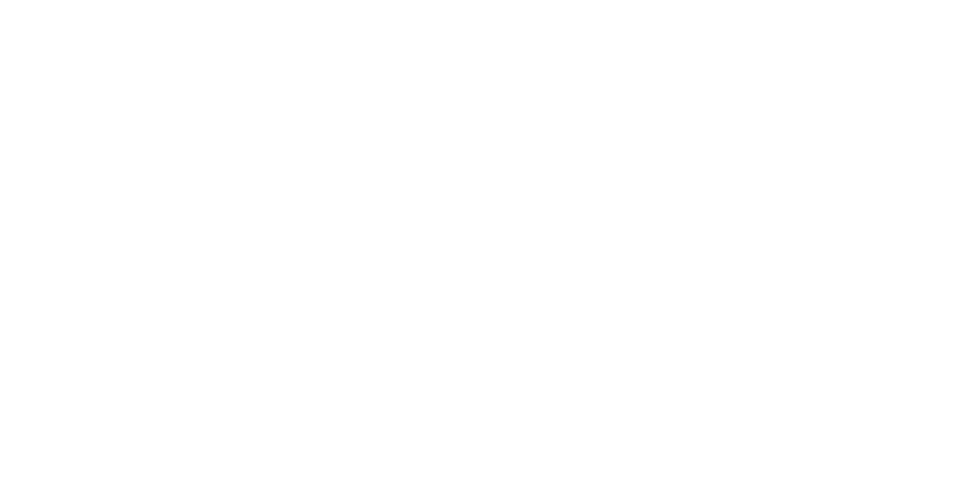

<IPython.core.display.Javascript object>


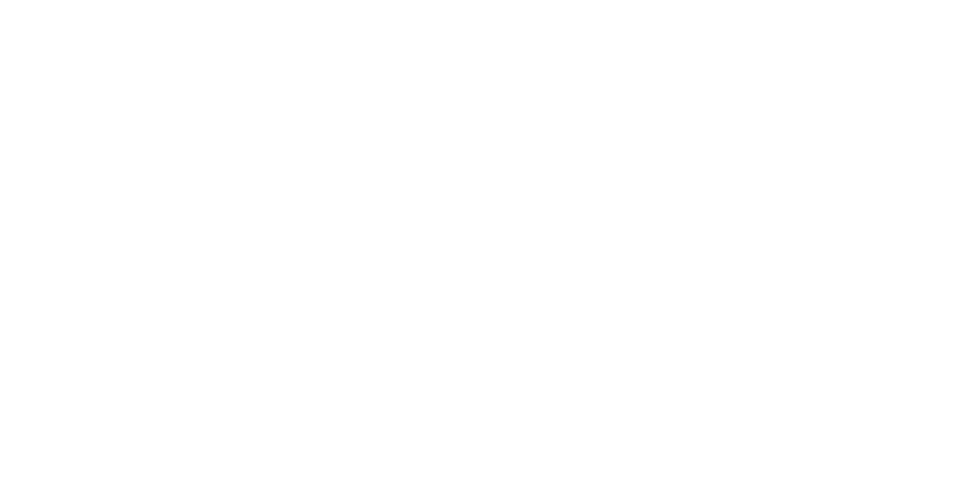

<IPython.core.display.Javascript object>


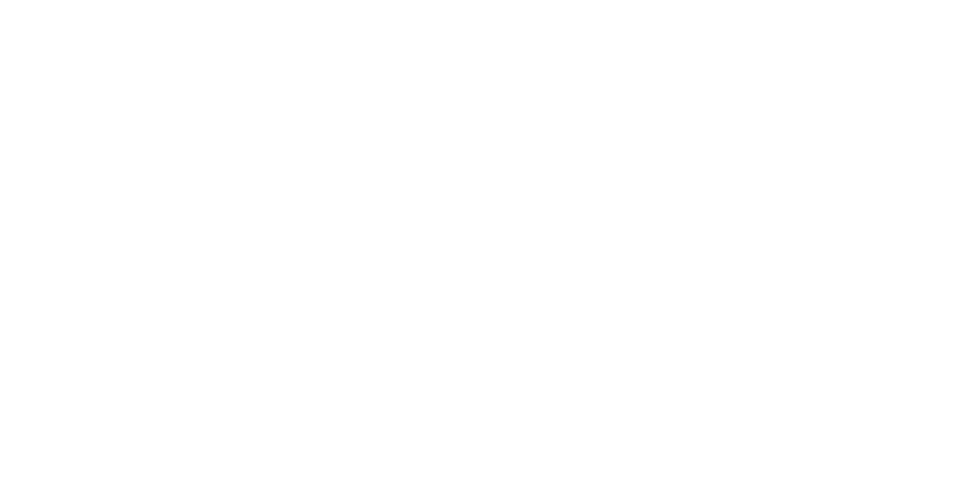

<IPython.core.display.Javascript object>


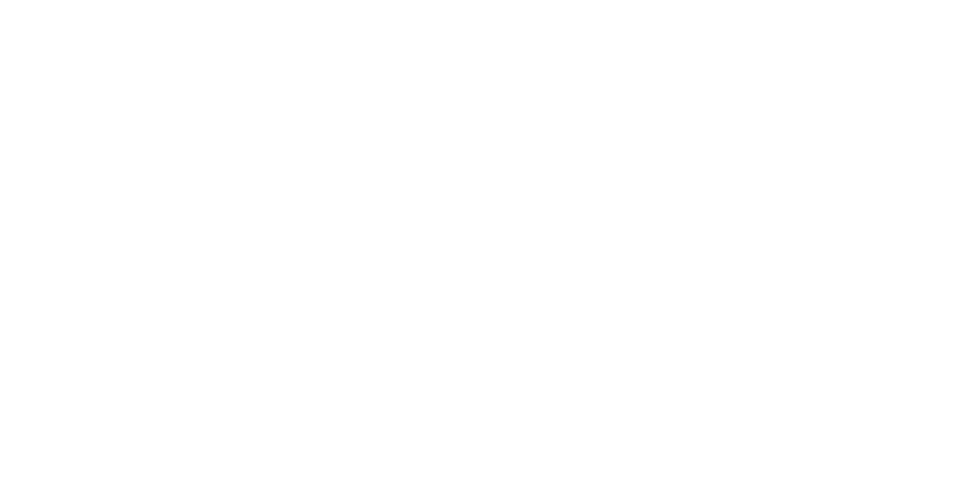

<IPython.core.display.Javascript object>


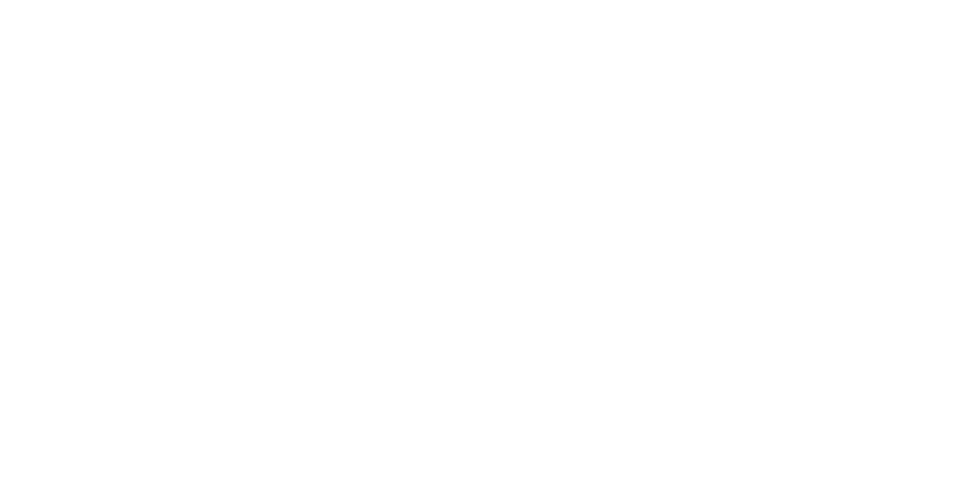

<IPython.core.display.Javascript object>


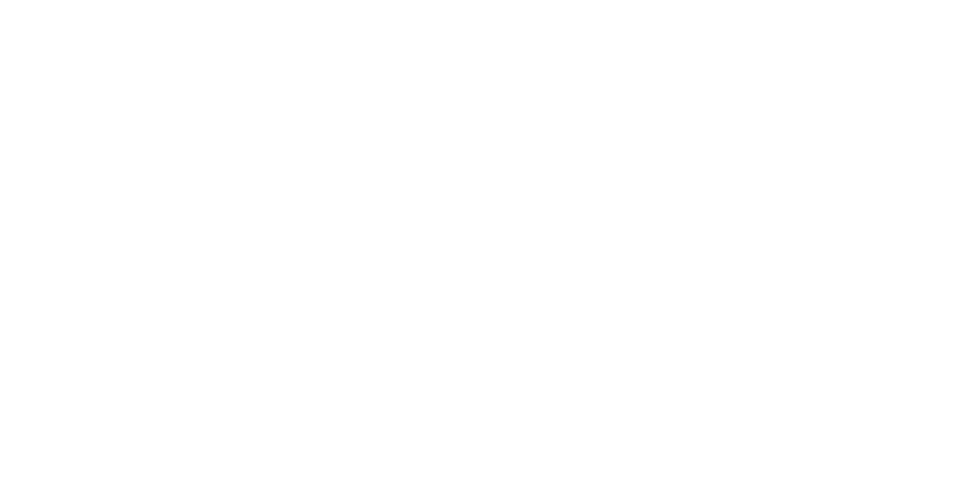

<IPython.core.display.Javascript object>


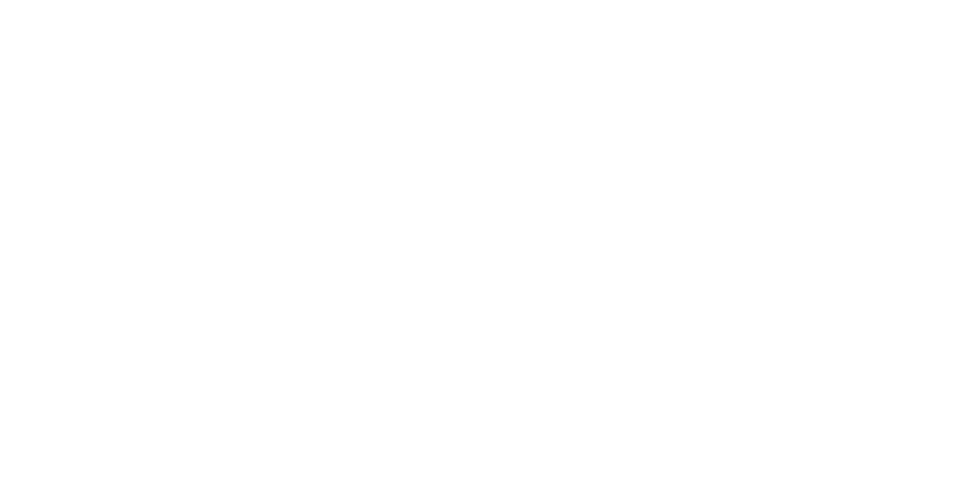

<IPython.core.display.Javascript object>


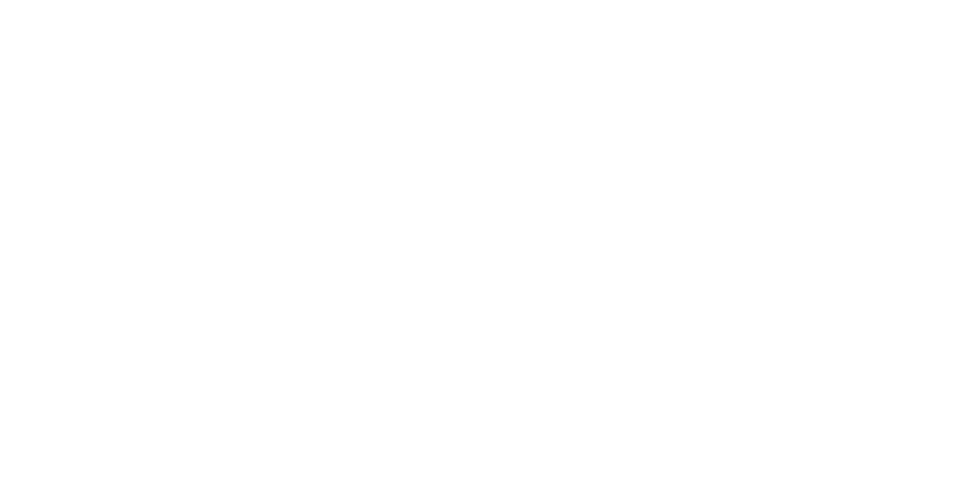

<IPython.core.display.Javascript object>


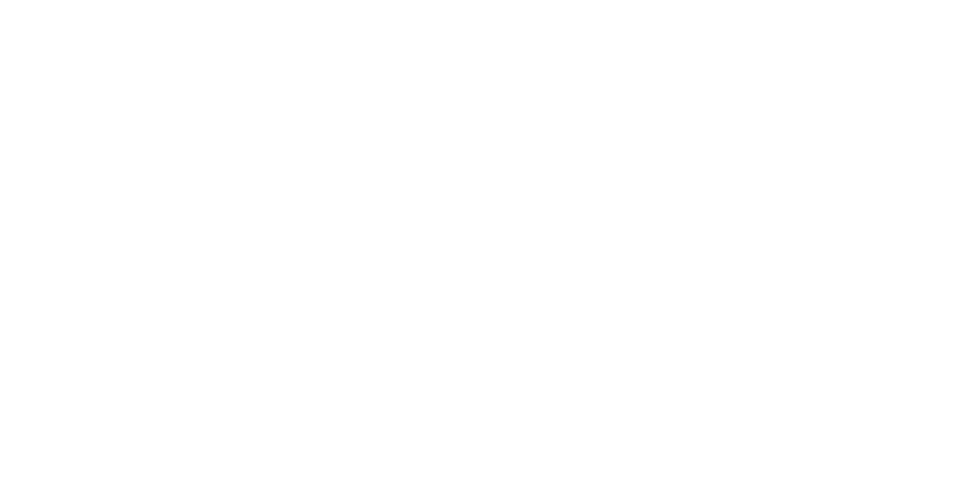

<IPython.core.display.Javascript object>


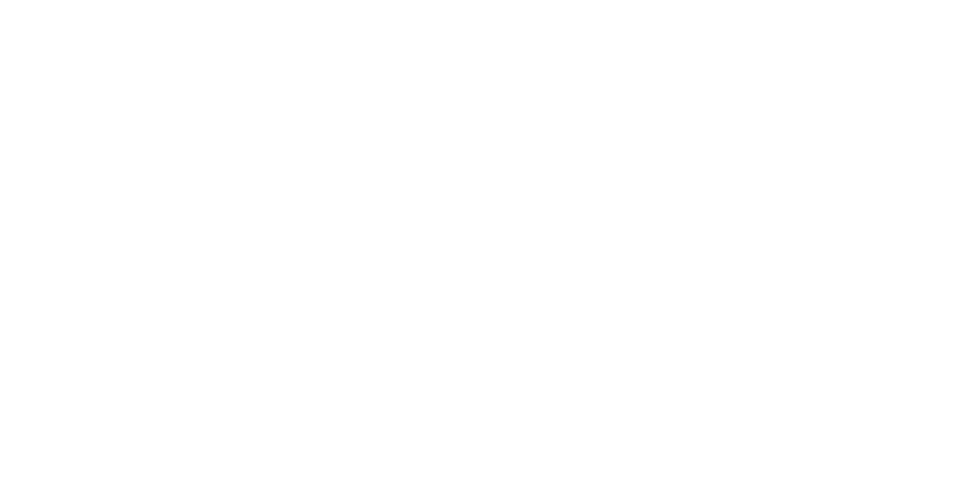

<IPython.core.display.Javascript object>


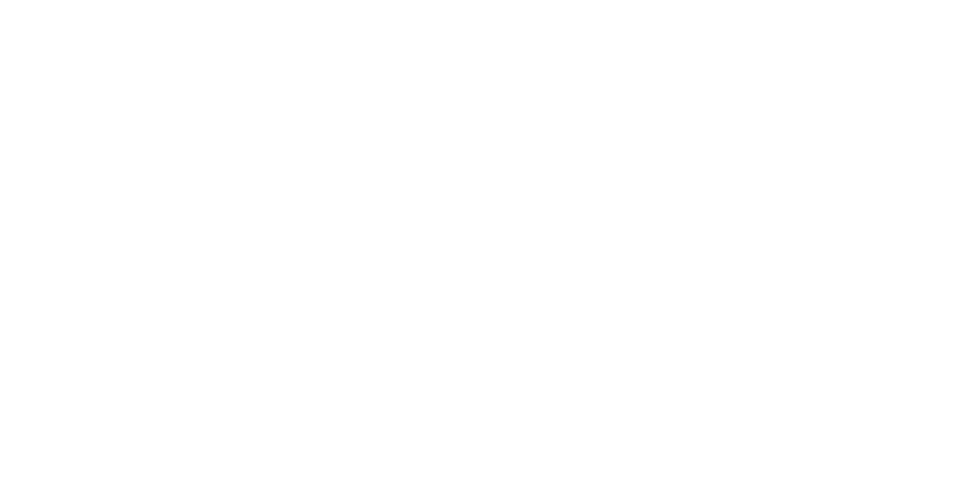

<IPython.core.display.Javascript object>


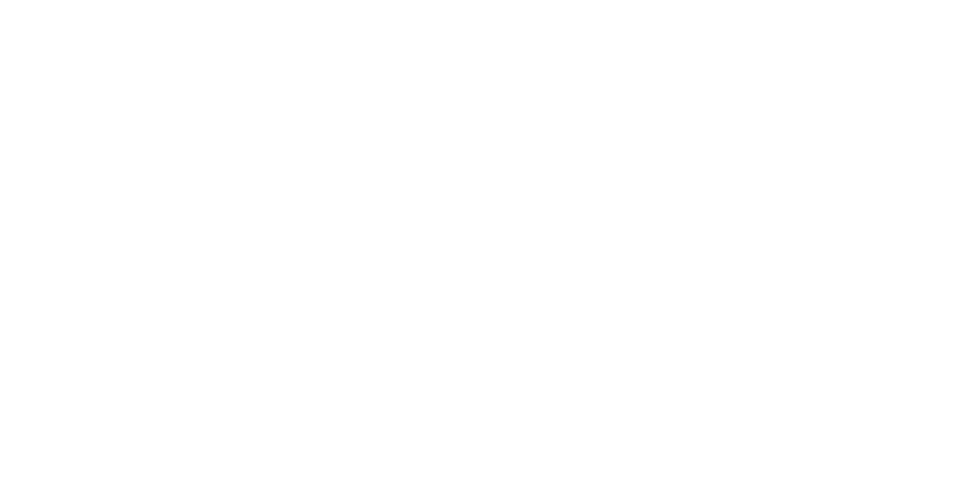

<IPython.core.display.Javascript object>


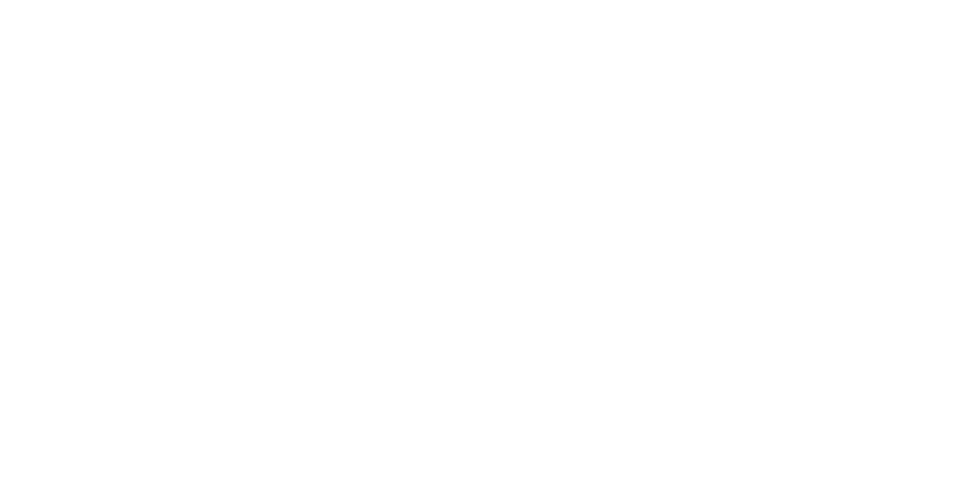

<IPython.core.display.Javascript object>


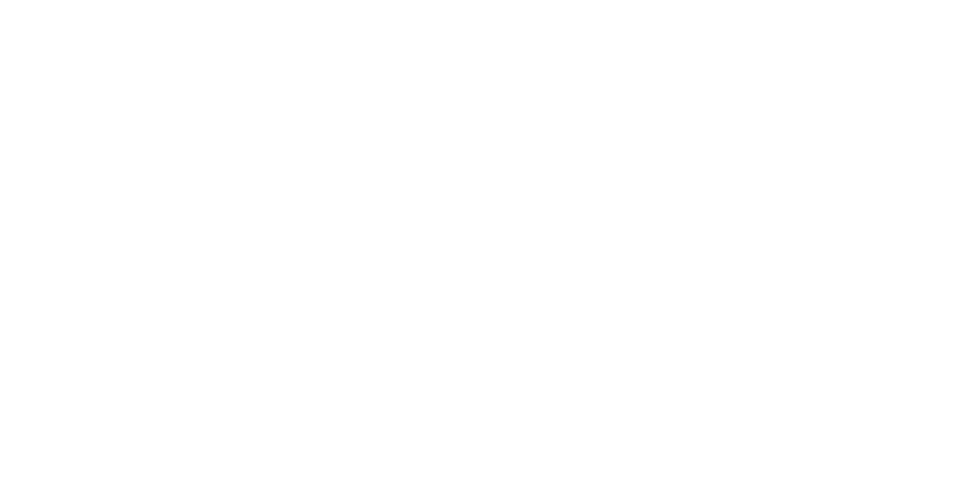

<IPython.core.display.Javascript object>


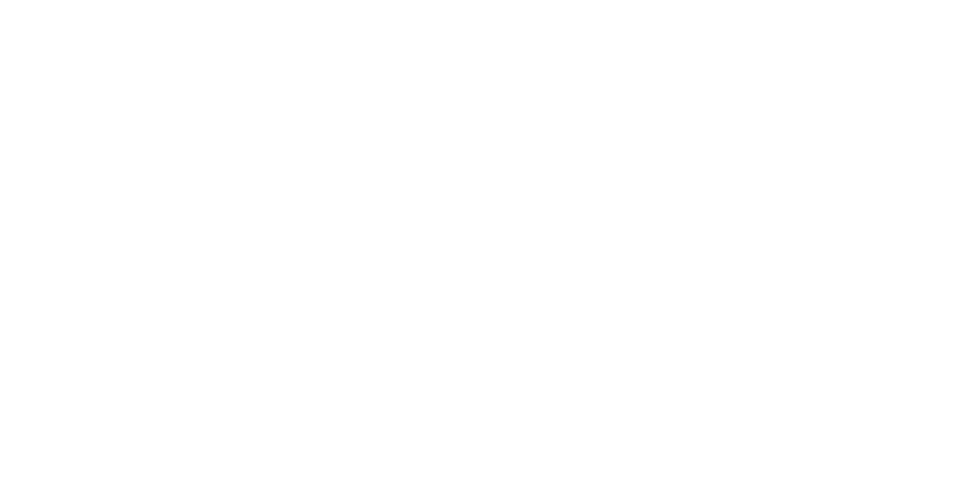

KeyboardInterrupt: 

In [10]:
"""
Generation of frames for a torque analysis animation. There is some wonkiness in the
results, so a doublecheck is required...
"""

from IPython.display import clear_output

mesh = pymesh.load_mesh('eros_low_detail.mesh'.format(detail_levels[level]))
data = np.loadtxt('data-{:s}.dat'.format(detail_levels[level]))
Γ = data.reshape([φ.size, β.size, λ.size, 3])

jjj = 0
for kkk in range(λ.size):
    for iii in range(β.size):
        βi = β[iii]
        λi = λ[kkk]
        R = Rot.from_euler('ZXY', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,R)
        Q = matmul(R, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(15,10,-10,0,0,20,length=1,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)

        ax2.plot(φ/(2*π),Γ[:,iii,kkk,0],label=r'$Γ_x$')
        ax2.plot(φ/(2*π),Γ[:,iii,kkk,1],'--',label=r'$Γ_y$')
        ax2.plot(φ/(2*π),Γ[:,iii,kkk,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1

    for iii in range(β.size-1):
        βi = β[-1 - iii]
        λi = λ[kkk]
        R = Rot.from_euler('ZXY', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,R)
        Q = matmul(R, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(15,10,-10,0,0,20,length=1,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)
        x, y = interp(φ, Γ, -1 - iii, kkk)
        ax2.plot(x/(2*π),y[:,0],label=r'$Γ_x$')
        ax2.plot(x/(2*π),y[:,1],'--',label=r'$Γ_y$')
        ax2.plot(x/(2*π),y[:,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1
        clear_output(wait=True)

In [ ]:
"""
RAT analogue calculations
"""# Alignment coordinates
ξ = np.linspace(0, π, 50)
φ = np.linspace(0, 2*π, 50)
ψ = 0

import time, datetime
Γ = np.zeros([ξ.size, 3])

start = time.time()
for i, xi in enumerate(ξ):
    if np.mod(i,1)==0: print((i+1),'/',ξ.size)
    for j, fj in enumerate(φ):
        #print(' ',(j+1),'/',β.size)
        Γ[i] += Γ_LS(P, T, C, N, φ = 0, β = xi, λ = fj)
            #print('  ',(k+1),'/',λ.size)
Γ = Γ/φ.size
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

In [ ]:
fig = plt.figure()
plt.plot(ξ/π,Γ[:,0],label='')
plt.xlabel('Rotational phase')
plt.ylabel('YORP alignment torque')
plt.xlim([0,1])
plt.show()